In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
import pprint

# Import API key
import api_keys

# Incorporated citipy to determine city based on latitude and longitude
from citipy import citipy

# Output File (CSV)
output_data_file = "output_data/cities.csv"

# Range of latitudes and longitudes
lat_range = (-90, 90)
lng_range = (-180, 180)

## Generate Cities List

In [2]:
# List for holding lat_lngs and cities
lat_lngs = []
cities = []

# Create a set of random lat and lng combinations
lats = np.random.uniform(low=-90.000, high=90.000, size=125)
lngs = np.random.uniform(low=-180.000, high=180.000, size=125)
lat_lngs = zip(lats, lngs)

# Identify nearest city for each lat, lng combination
for lat_lng in lat_lngs:
    city = citipy.nearest_city(lat_lng[0], lat_lng[1]).city_name
    
    # If the city is unique, then add it to a our cities list
    if city not in cities:
        cities.append(city)
# Print the city count to confirm sufficient count
print(len(cities))


97


In [3]:
#create a df of cities
city_df_blank=pd.DataFrame(cities, columns=['City'])
#city_df.rename(columns={0:'New'})

#add new fields to df
def add_fields(x):
    x['Temperature (F)']=""
    x['Humitidy (%)']=""
    x['Cloudiness (%)']=""
    x['Wind Speed (mph)']=""
    x['Lattitude']=""
    x['Longitude']=""
    x['Distance From Equator']=""

add_fields(city_df_blank)#apply function



## Perform API Calls

In [4]:


# OpenWeatherMap API Key
api_key = api_keys.api_key

# Starting URL for Weather Map API Call
url = "http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID=" + api_key #+f"&q={city_df['City'][0]}"
url

'http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID=48c662d8e2fbc87db3c1601e94215d84'

In [5]:
city_df_raw=city_df_blank
# response = requests.get(url)
# r=response.json()
base_url = "http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID=" + api_key
missing=0
# use iterrows to iterate through pandas dataframe
for index, row in city_df_raw.iterrows():
    
    # get restaurant type from df
    city_to_find = row['City']

    # assemble url and make API request
    #print(f"Retrieving Results for Index {index}: {city_to_find}.")
    response = requests.get(base_url+f'&q={city_to_find}').json()

    try:
        #print(response)#(f"Temp is results['main']['temp'] in row['City'].")

        city_df_raw.loc[index,'Temperature (F)'] = float(response['main']['temp'])
        city_df_raw.loc[index,'Lattitude'] = response['coord']['lat']
        city_df_raw.loc[index,'Longitude'] = response['coord']['lon']
        city_df_raw.loc[index,'Humitidy (%)'] = response['main']['humidity']
        city_df_raw.loc[index,'Cloudiness (%)'] = response['clouds']['all']
        city_df_raw.loc[index,'Wind Speed (mph)'] = response['wind']['speed']
        
    except (KeyError, IndexError):
        missing +=1
print(f'missing: {missing}')
print('Start ' +str(len(cities)))

missing: 7
Start 97


In [10]:
#city_df_raw['Lattitude'][0]
city_df_clean=city_df_raw

city_df_clean.replace('',np.nan, inplace=True)
city_df_clean['Distance From Equator']=abs(0 - city_df_clean['Lattitude'])


city_df_clean.head()

# city_df_clean

,City,Temperature (F),Humitidy (%),Cloudiness (%),Wind Speed (mph),Lattitude,Longitude,Distance From Equator
0,palmas bellas,87.80,66.0,40.0,4.70,9.23,-80.09,9.23
1,peshkopi,77.00,83.0,0.0,1.12,41.68,20.43,41.68
2,butaritari,83.49,100.0,64.0,9.33,3.07,172.79,3.07
3,yellowknife,69.80,60.0,40.0,16.11,62.45,-114.38,62.45
4,borogontsy,56.76,91.0,0.0,5.86,62.67,131.17,62.67


C:\Users\warne\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.


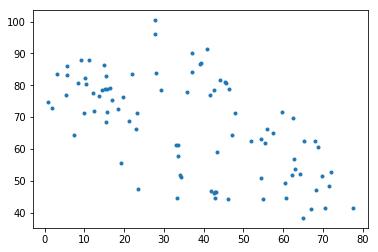

In [26]:
xax=city_df_clean['Distance From Equator']
yax=city_df_clean['Temperature (F)']

b, m = np.polyfit(xax, yax, 1)

plt.plot(xax, yax, '.')
plt.plot(xax, b + m * xax, '-')
plt.show()

In [8]:
# print(city_df.head())
# #city_df.loc[city_df['Cloudiness (%)'] ==44]

# city_df['Longitude'].convert_objects(convert_numeric=True)
# city_df['Longitude'].apply(pd.to_numeric)
# #city_df.loc[city_df['Longitude']>-0.6]

# city_df.loc[city_df['Longitude']>90]
# city_df['Longitude'].convert_objects
# city_df['Longitude'] = pd.to_numeric(city_df['Longitude'])

# def convert_to_float(x,y):
#     try:
#         pd.to_numeric(x[y])
#     except:
#         next
# new_df= city_df.apply(convert_to_float)


# city_df[['Lattitude','Longitude']].apply(pd.to_numeric)
# city_df.dtypes
# #how do i create a function to convert all cols to float AND keep str columns???